In [ ]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Default dimensions
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = "drive/MyDrive/Colab Notebooks/bottleneck_fc_model.h5"
# loading up our datasets
train_data_dir = 'drive/MyDrive/Colab Notebooks/train2_agreed/'
validation_data_dir = 'drive/MyDrive/Colab Notebooks/val2_agreed/'
 
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 50 

In [ ]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) 
#needed to create the bottleneck .npy files

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
#For training in VGG16
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 
 
np.save("bottleneck_features_train.npy", bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)

Found 6134 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Time:  0:45:57.369020


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/train2_agreed.npy', 'rb') as handle:
        bottleneck_features_train = pickle.load(handle)
np.save('bottleneck_features_train.npy', bottleneck_features_train) 

In [ ]:
#predicition of validation images using vgg16
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1961 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:14:41.932267


In [ ]:
#training data 
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 6126 images belonging to 5 classes.


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/val2_agreed.npy', 'rb') as handle:
        bottleneck_features_validation = pickle.load(handle)
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 

In [ ]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 998 images belonging to 5 classes.


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/test2_agreed.npy', 'rb') as handle:
        bottleneck_features_test = pickle.load(handle)
np.save('bottleneck_features_test.npy', bottleneck_features_test) 

In [ ]:
#test data
test_data_dir='/content/drive/MyDrive/Colab Notebooks/test2_agreed'
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 955 images belonging to 5 classes.


# Definig the Modal

In [ ]:
#Fine tuning the model by adding dense and drop layer after vgg16 prediction
start = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation="softmax"))
model.compile(loss="categorical_crossentropy",
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=['acc'])
history = model.fit(train_data, train_labels, 
   epochs=7,
   batch_size=batch_size, 
   validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate( 
    validation_data, validation_labels, batch_size=batch_size,     verbose=1)
print('[INFO] accuracy: {:.2f}%'.format(eval_accuracy * 100)) 
print('[INFO] Loss: {}'.format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)

Epoch 1/7
123/123 [==============================] - 6s 42ms/step - loss: 1.2704 - acc: 0.5334 - val_loss: 0.8357 - val_acc: 0.6523
Epoch 2/7
123/123 [==============================] - 5s 39ms/step - loss: 0.8543 - acc: 0.6701 - val_loss: 0.7711 - val_acc: 0.6914
Epoch 3/7
123/123 [==============================] - 5s 39ms/step - loss: 0.7653 - acc: 0.7119 - val_loss: 0.7712 - val_acc: 0.6884
Epoch 4/7
123/123 [==============================] - 5s 39ms/step - loss: 0.7027 - acc: 0.7336 - val_loss: 0.8881 - val_acc: 0.6703
Epoch 5/7
123/123 [==============================] - 5s 39ms/step - loss: 0.6623 - acc: 0.7549 - val_loss: 0.8032 - val_acc: 0.6974
Epoch 6/7
123/123 [==============================] - 5s 39ms/step - loss: 0.5846 - acc: 0.7934 - val_loss: 0.7867 - val_acc: 0.6894
Epoch 7/7
20/20 [==============================] - 0s 10ms/step - loss: 0.8501 - acc: 0.7064
[INFO] accuracy: 70.64%
[INFO] Loss: 0.8501218557357788
Time:  0:00:35.634144


In [ ]:
model.save_weights("drive/MyDrive/Colab Notebooks/multi.h5")

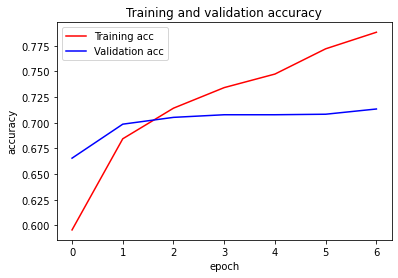

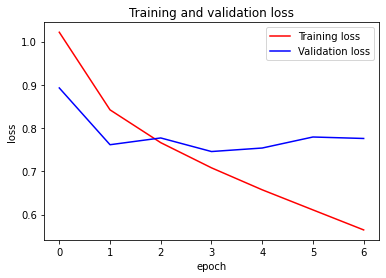

In [ ]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()


In [ ]:
model.evaluate(test_data, test_labels)

30/30 [==============================] - 0s 8ms/step - loss: 0.7943 - acc: 0.7309


[0.7942876219749451, 0.7308900356292725]

In [ ]:

print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    8.53747606e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    9.53642547e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    9.02669668e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 1.19742465e+00 ... 0.00000000e+00
    8.32436919e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.17772102e+00 ... 2.69638479e-01
    1.38697517e+00 0.00000000e+00]
   [3.16119194e-03 0.00000000e+00 1.29021436e-01 ... 0.00000000e+00
    1.08915985e+00 0.00000000e+00]]

  [[1.59990758e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.99156070e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.41874981e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 4.61622357e-01 ... 0.00000000e+00
    9.91268516e-01 0.00000000e+00]
   ...
   [1.26131400e-01 0.00000000e+00 1.12414837e+0

In [ ]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [ ]:
target_names = ['Affected_Individuals', 'Infrastructure_and_Utility_damage', 'Not_Humanitarian','Other_Relevant_information','Rescue_Volunteering']
classification_metrics = metrics.classification_report(categorical_test_labels, categorical_preds, target_names=target_names,digits=4 )
print(classification_metrics)

                                   precision    recall  f1-score   support

             Affected_Individuals     0.0164    0.1111    0.0286         9
Infrastructure_and_Utility_damage     0.7742    0.2963    0.4286        81
                 Not_Humanitarian     0.7242    0.8909    0.7989       504
       Other_Relevant_information     0.8994    0.6468    0.7525       235
              Rescue_Volunteering     0.5946    0.3492    0.4400       126

                         accuracy                         0.7016       955
                        macro avg     0.6018    0.4589    0.4897       955
                     weighted avg     0.7478    0.7016    0.7015       955



In [ ]:
#converting back to 1 class output
categorical_test_labels = pd.DataFrame(validation_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [ ]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [ ]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


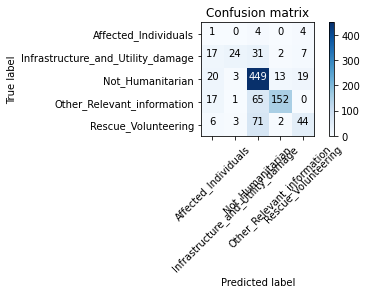

In [ ]:
plot_confusion_matrix(confusion_matrix, target_names)